![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb)

# Clinical Entity Resolvers

## Colab Setup

In [ ]:
import json

with open('license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

secret = license_keys['secret']
os.environ['SPARK_NLP_LICENSE'] = license_json['SPARK_NLP_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_json['JSL_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_json['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_json['AWS_SECRET_ACCESS_KEY']

! python -m pip install --upgrade spark-nlp-jsl==2.4.2  --extra-index-url https://pypi.johnsnowlabs.com/$secret

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl


def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "8G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "900M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-2.4.2.jar")
      
    return builder.getOrCreate()


spark = start(secret) # if you want to start the session with custom params as in start function above
# sparknlp_jsl.start(secret)

In [ ]:

# if you want to load the licensed models from S3 with your license key

! pip install awscli --upgrade

In [ ]:
spark

# Clinical Resolvers

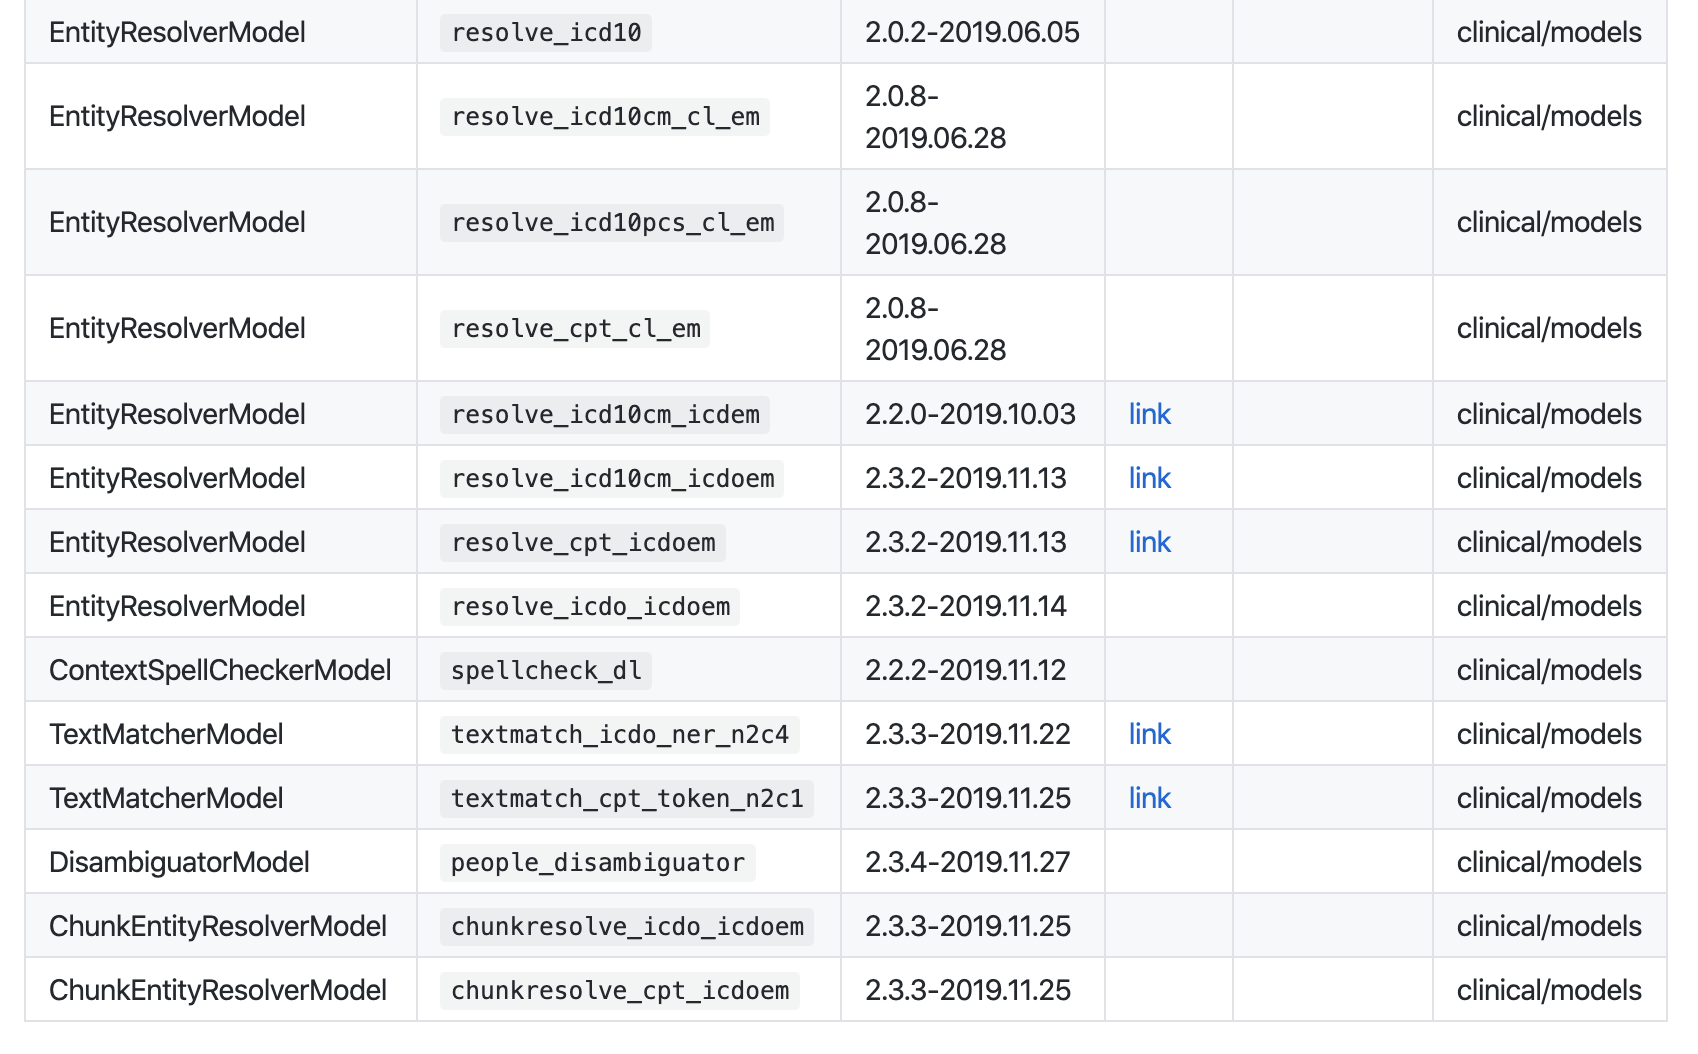

## Entity Resolvers for ICD-10

In [ ]:
import pandas as pd
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F
import string
import numpy as np
import sparknlp
from sparknlp.util import *
from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F
from sparknlp_jsl.annotator import *

In [ ]:
from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
!aws s3 cp s3://auxdata.johnsnowlabs.com/clinical/models/chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip

download: s3://auxdata.johnsnowlabs.com/clinical/models/chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip to ./chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip


In [ ]:
!unzip chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip -d chunkresolve_icd10cm

Archive:  chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip
  inflating: chunkresolve_icd10cm/metadata/._SUCCESS.crc  
  inflating: chunkresolve_icd10cm/metadata/_SUCCESS  
  inflating: chunkresolve_icd10cm/metadata/part-00000  
  inflating: chunkresolve_icd10cm/metadata/.part-00000.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/.part-00006.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/.part-00018.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/.part-00016.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/part-00021  
  inflating: chunkresolve_icd10cm/fields/searchTree/part-00010  
  inflating: chunkresolve_icd10cm/fields/searchTree/part-00008  
  inflating: chunkresolve_icd10cm/fields/searchTree/.part-00011.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/._SUCCESS.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/.part-00014.crc  
  inflating: chunkresolve_icd10cm/fields/searchTree/part-00004  
  inflating: chunkres

In [ ]:
icd_ner_converter = NerConverter()\
  .setInputCols(["sentence", "token", "ner"])\
  .setOutputCol("ner_chunk")\
.setWhiteList(['PROBLEM'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")\

chunk_tokenizer = ChunkTokenizer()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_token")


entity_resolver_icd10 = ChunkEntityResolverModel.load("chunkresolve_icd10cm")\
         .setInputCols(["ner_token", "chunk_embeddings"])\
         .setOutputCol("icd10cm_code")\
         .setDistanceFunction("COSINE")

pipeline_icd10 = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    icd_ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    entity_resolver_icd10
  ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model_icd10 = pipeline_icd10.fit(empty_data)


In [ ]:
! wget 	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv


--2020-04-09 19:35:54--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.14.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.14.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9363435 (8.9M) [text/csv]
Saving to: ‘pubmed_sample_text_small.csv’

pubmed_sample_text_ 100%[===================>]   8.93M  --.-KB/s    in 0.1s    

2020-04-09 19:35:54 (69.1 MB/s) - ‘pubmed_sample_text_small.csv’ saved [9363435/9363435]



In [ ]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"""Monomeric sarcosine oxidase (MSOX) is a flav...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
result = model_icd10.transform(pubMedDF.limit(100))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|    chunk_embeddings|           ner_token|        icd10cm_code|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 210, 254...|[[word_embeddings...|[[token, 210, 210...|[[entity, 210, 25...|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 84, 96, ...|[[wo

In [ ]:
def get_icd10_codes(model, text):
    
    data = spark.createDataFrame([[text]]).toDF("text")
        
    output = model.transform(data)
    
    result = output.select(F.explode(F.arrays_zip("ner_chunk.begin",
                                         "ner_chunk.end",
                                         "ner_chunk.result", "ner_chunk.metadata", "icd10cm_code.result", "icd10cm_code.metadata")).alias("icd10cm_result")) \
    .select(F.expr("icd10cm_result['2']").alias("ner"),
            F.expr("icd10cm_result['3'].entity").alias("entity"),
            F.expr("icd10cm_result['0']").alias("begin"),
            F.expr("icd10cm_result['1']").alias("end"),
            F.expr("icd10cm_result['4']").alias("code"),
            F.expr("icd10cm_result['5'].resolved_text").alias("resolved_text"),
            F.expr("icd10cm_result['5'].alternative_codes").alias("alternative_codes"),
            F.expr("round(icd10cm_result['5'].confidence_ratio,2)").alias("confidence_ratio"))\
    .distinct()\
    .toPandas()
    
    return result

In [ ]:
%%time

text = 'He has a brain damage and lung cancer'

df = get_icd10_codes(model_icd10, text)

CPU times: user 109 ms, sys: 18 ms, total: 127 ms
Wall time: 6.03 s


In [ ]:
df

,ner,entity,begin,end,code,resolved_text,alternative_codes,confidence_ratio
0,lung cancer,PROBLEM,26,36,C220,Liver cell carcinoma,C61:|:C61:|:J675:|:J674:|:J670:|:J672:|:J670:|...,1.38
1,a brain damage,PROBLEM,7,20,Z87820,Personal history of traumatic brain injury,P112:|:Z13850:|:P112:|:G931:|:P111:|:S062X7A:|...,1.02


# RxNorm Resolver

In [ ]:
rxnorm_resolution_l1 = DocumentLogRegClassifierModel.pretrained("resolve_rxnorm_clinical_l1", "en", "clinical/models")\
    .setInputCols("ner_token").setOutputCol("partition")

rxnorm_resolution_l2 = ResourceDownloader.downloadPipeline("resolve_rxnorm_clinical_l2", "en", "clinical/models")

rxnorm_resolution = PipelineModel([rxnorm_resolution_l1, RecursivePipelineModel(rxnorm_resolution_l2)])

posology_ner_model_large = NerDLModel.pretrained('ner_posology', "en", "clinical/models")\
            .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

drug_converter = NerConverter()\
  .setInputCols(["sentence", "token", "ner"])\
  .setOutputCol("ner_chunk")\
.setWhiteList(['DRUG'])

pipeline_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner_model_large,
    drug_converter,
    chunk_embeddings,
    chunk_tokenizer,
    rxnorm_resolution
  ])

model_rxnorm = pipeline_rx.fit(empty_data)
    


resolve_rxnorm_clinical_l1 download started this may take some time.
Approximate size to download 7.5 MB
[OK!]
resolve_rxnorm_clinical_l2 download started this may take some time.
Approx size to download 276.1 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]


In [ ]:
def get_rxnorm_codes(text):
    
    data = spark.createDataFrame([[text]]).toDF("text")
        
    output = model_rxnorm.transform(data)
    
    result = output.select(F.explode(F.arrays_zip("ner_chunk.begin",
                                     "ner_chunk.end",
                                     "ner_chunk.result", "ner_chunk.metadata", "rxnorm_code.result", "rxnorm_code.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['2']").alias("ner"),
            F.expr("rxnorm_result['3'].entity").alias("entity"),
            F.expr("rxnorm_result['0']").alias("begin"),
            F.expr("rxnorm_result['1']").alias("end"),
            F.expr("rxnorm_result['4']").alias("code"),
            F.expr("rxnorm_result['5'].resolved_text").alias("resolved_text"),
            F.expr("rxnorm_result['5'].alternative_codes").alias("alternative_codes"),
            F.expr("round(rxnorm_result['5'].confidence_ratio,2)").alias("confidence_ratio")) \
    .distinct()\
    .toPandas()
    
    return result



In [ ]:

text = 'He has a brain damage and needs to take an Advil and Aspirin'

get_rxnorm_codes(text)

,ner,entity,begin,end,code,resolved_text,alternative_codes,confidence_ratio
0,Advil,DRUG,43,47,352893,phoslo gelcap,1941952:|:1318187:|:827207:|:19711,1.01
1,Aspirin,DRUG,53,59,238143,aspirin pwdr,238143:|:687078:|:1986390:|:226716,1.00


## Snomed Resolver

In [ ]:
 #SNOMED Resolution
ner_snomed_resolver_l1 = DocumentLogRegClassifierModel.pretrained("resolve_snomed_clinical_l1", "en", "clinical/models")\
    .setInputCols("ner_token").setOutputCol("partition")

ner_snomed_resolver_l2 = ResourceDownloader.downloadPipeline("resolve_snomed_clinical_l2", "en", "clinical/models")


ner_snomed_resolver_l2.stages[-1].setInputCols("partition","ner_token","chunk_embeddings")


resolve_snomed_clinical_l1 download started this may take some time.
Approximate size to download 15.3 MB
[OK!]
resolve_snomed_clinical_l2 download started this may take some time.
Approx size to download 583.4 MB
[OK!]


ChunkEntityResolverSelector_d41a7a88595b

In [ ]:
from pyspark.ml import PipelineModel

snomed_resolution = PipelineModel([ner_snomed_resolver_l1, RecursivePipelineModel(ner_snomed_resolver_l2)])


In [ ]:
clinical_converter = NerConverter()\
  .setInputCols(["sentence", "token", "ner"])\
  .setOutputCol("ner_chunk")


def get_snomed_model():
    pipeline_snomed = Pipeline(
        stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        posology_ner_model_large,
        clinical_converter,
        chunk_embeddings,
        chunk_tokenizer,
        snomed_resolution
      ])

    model_snomed = pipeline_snomed.fit(empty_data)
    
    return model_snomed


model_snomed = get_snomed_model()

In [ ]:
def get_snomed_codes(text):
    
    data = spark.createDataFrame([[text]]).toDF("text")
    
    output = model_snomed.transform(data)
        
    result = output.select(F.explode(F.arrays_zip("ner_chunk.begin",
                                     "ner_chunk.end",
                                         "ner_chunk.result", "ner_chunk.metadata", "snomed_code.result", "snomed_code.metadata")).alias("snomed_result")) \
    .select(F.expr("snomed_result['2']").alias("ner"),
            F.expr("snomed_result['3'].entity").alias("entity"),
            F.expr("snomed_result['0']").alias("begin"),
            F.expr("snomed_result['1']").alias("end"),
            F.expr("snomed_result['4']").alias("code"),
            F.expr("snomed_result['5'].resolved_text").alias("resolved_text"),
            F.expr("snomed_result['5'].alternative_codes").alias("alternative_codes"),
            F.expr("round(snomed_result['5'].confidence_ratio,2)").alias("confidence_ratio")) \
    .distinct()\
    .toPandas()

    return result


In [ ]:
%%time

text = 'He has a brain damage and needs to take Parol or Aspirin'

df = get_snomed_codes(text)

CPU times: user 469 ms, sys: 105 ms, total: 575 ms
Wall time: 22.5 s


In [ ]:
df

,ner,entity,begin,end,code,resolved_text,alternative_codes,confidence_ratio
0,Aspirin,DRUG,49,55,312452009,aspirin prophylaxis,717854002:|:413081008:|:243195000:|:243195000,1.05
1,Parol,DRUG,40,44,,,,NaN
